# Simulated annealing for the TSP

CSI4106 Artificial Intelligence  
Fall 2018  
Caroline Barrière

This homework will allow you to look deeper into one of the randomized searches presented in class, that of *Simulated Annealing*. It is a good example of a *random modification* algorithm, in which we start with a greedy solution, and then make changes and accept the modified solutions with different probabilities given their level of fitness to a cost function.

The application domain for experimenting with *simulated annealing* is the traveling salesman problem (TSP), which is a classical problem of scheduling, with optimization on the cost of travel.

***HOMEWORK***:  
Go through the notebook by running each cell, one at a time.  
Look for **(TO DO)** for the tasks that you need to perform.  Once you're done, Sign the notebook (see the added step at the end), and submit it.  
***

**1. Let's start with a small set of cities.**

In [1]:
# let's define 5 cities with a label and a (x,y) coordinate
cities = {'A': (0,0), 'B': (1,1), 'C': (1,0), 'D': (-1,1), 'E': (-1,-1)}

Let's plot the nodes using the *showNodes* method below.  
The packages matplotlib and networkx must be installed first.  
To do so, open a command prompt and type **pip install matplotlib**, and also **pip install networkx**.  After the packages are installed, you'll have to restart the kernel.  Then, you will be able to run the following cell.  

In [2]:
import matplotlib.pyplot as plt
import networkx as nx

# small method to show nodes
# provide defaults for figure size (size), as well as x and y axis
def showNodes(nodeDict, size= (6.5, 4), xLim=[-2,2], yLim=[-2,2]):
    fig = plt.figure(figsize=size)
    axg = fig.add_subplot(111)
    axg.set_xlim(xLim)
    axg.set_ylim(yLim)

    G=nx.Graph()
    for k in nodeDict.keys():
        G.add_node(k, coor=nodeDict.get(k))
    
    pos=nx.get_node_attributes(G,'coor')
    nx.draw(G, pos, with_labels = True)
    plt.axis('on')
    plt.show()

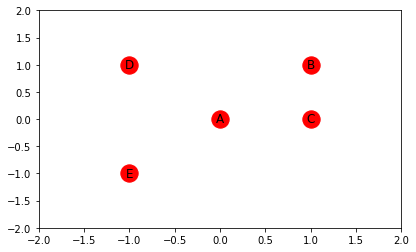

In [3]:
# show the cities on a map
showNodes(cities)

#### 2. Let's find the distances between all cities.
First, we define a method to calculate the distance between two specific cities, and then a method to find the distances between all pairs of nodes.

In [4]:
import math

# returns the euclidian distance between two nodes
def dist(node1, node2):
    return round(math.sqrt(math.pow(node1[0] - node2[0], 2) + math.pow(node1[1] - node2[1], 2)), 3)

In [5]:
# Small test to see the distance
dist(cities.get('A'), cities.get('B'))

1.414

In [6]:
# building a dictionary of all pairs or ditances
def distDict(nodes):
    distance = {}
    # go through all pairs of nodes
    for k in nodes.keys():
        for m in nodes.keys():
            distance[k,m] = dist(nodes.get(k), nodes.get(m))
    return distance

In [7]:
# showing the distances between the cities
distances = distDict(cities)
print(distances)

{('A', 'A'): 0.0, ('A', 'B'): 1.414, ('A', 'C'): 1.0, ('A', 'D'): 1.414, ('A', 'E'): 1.414, ('B', 'A'): 1.414, ('B', 'B'): 0.0, ('B', 'C'): 1.0, ('B', 'D'): 2.0, ('B', 'E'): 2.828, ('C', 'A'): 1.0, ('C', 'B'): 1.0, ('C', 'C'): 0.0, ('C', 'D'): 2.236, ('C', 'E'): 2.236, ('D', 'A'): 1.414, ('D', 'B'): 2.0, ('D', 'C'): 2.236, ('D', 'D'): 0.0, ('D', 'E'): 2.0, ('E', 'A'): 1.414, ('E', 'B'): 2.828, ('E', 'C'): 2.236, ('E', 'D'): 2.0, ('E', 'E'): 0.0}


Let's also add a method to find the closest city to a city.  That will be helpful later.

In [8]:
# find the min distance from node1 to all other nodes.
# it receives the node1 label, the labels of other nodes to test,
# and the precalculated distances between all nodes
def closestNode(node1_label, otherNodes_Labels, distanceDict):
    # tricky syntax... it creates tuples where the distance is the first element of the tuple
    # and the position in the array is the second element of the tuple
    minDist = min( (distanceDict[node1_label,k], k) for k in otherNodes_Labels)
    # get the second element of the tuple which is the index found
    foundNode = minDist[1]
    return foundNode

In [9]:
# Testing the closest node
closestNode('B', ['C', 'D'], distances)

'C'

#### 3. Greedy solution first 
Before we can apply *simulated annealing*, we must first find a suboptimal solution which we will refine.

In [10]:
# greedy solution
import random

def greedy_solution(nodes):
    # distance matrix
    allDist = distDict(nodes)
    # pick a first node at random among the set of keys (node names)
    cur_node = random.choice(list(nodes.keys()))
    # add that node to solution
    solution = [cur_node]
    # build a free list of nodes (not yet used) containing all nodes except the one just chosen 
    free_list = list(nodes.keys())
    free_list.remove(cur_node)
    
    # while there are still nodes to be attached
    while free_list:
        # find the closestNode
        found_node = closestNode(cur_node, free_list, allDist)
        cur_node = found_node
        free_list.remove(cur_node)
        solution.append(cur_node)

    return solution

In [11]:
# Test obtaining a greedy solution
gs = greedy_solution(cities)
print(gs)

['C', 'A', 'B', 'D', 'E']


#### 4. Showing a path.  
We slightly modify to showNodes method from before, to become showPath, wich is now a directed graph.

In [12]:
# small method to show a path
# it receives an ordered list of nodes e.g. ['B','C','A', 'D', 'E']
# and a dictionary of all the nodes and their positions
def showPath(path, nodeDict, size= (6.5, 4), xLim=[-2,2], yLim=[-2,2]):
    fig = plt.figure(figsize=size)
    axg = fig.add_subplot(111)
    axg.set_xlim(xLim)
    axg.set_ylim(yLim)

    G=nx.DiGraph()
    for k in path:
        G.add_node(k, pos=nodeDict.get(k))
        
    for i in range(len(path) - 1):
        x = path[i]
        y = path[i + 1]
        G.add_edge(x,y)
        
    pos=nx.get_node_attributes(G,'pos')
    nx.draw(G, pos, with_labels = True, edge_color = 'b', arrows=True)   
    # nx.draw(G, pos, with_labels = True)
    plt.axis('on')
    plt.show()

A test to visualize two greedy solutions.

['C', 'A', 'B', 'D', 'E']


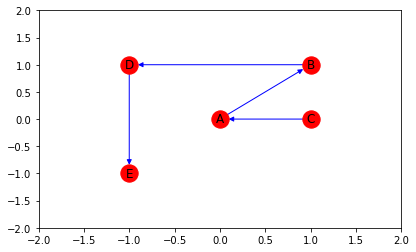

['C', 'A', 'B', 'D', 'E']


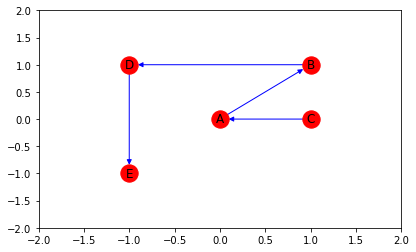

['A', 'C', 'B', 'D', 'E']


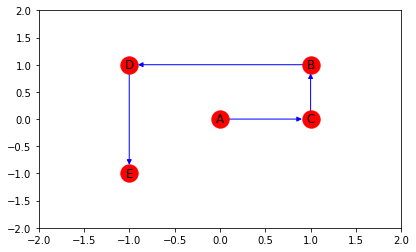

In [17]:
# Testing to output the path chosen by the greedy solution
print(gs)
showPath(gs, cities)
gs1 = greedy_solution(cities)
print(gs1)
showPath(gs1, cities)
gs2 = greedy_solution(cities)
print(gs2)
showPath(gs2, cities)

**(Q1 - TO DO)**  Run the test above a few times until you have different solutions.  How many times did you have to run your code above to actually obtain two *different* solutions?  And what are the solutions generated?

I added the example from above just to see if it would produce the correct result, it did. Since I didnt recall that earlier function it will not be random and my first example will stay the same. The next 2 original examples did change, and those results are demonstrated below. 


Nb of runs : 2 
Solutions generated : [D, A, C, B, E] --> [A,C,B,D,E], and [E,A,C,B,D] --> [C,A,B,D,E]

**(Q2 - TO DO)** Complete the method to find the total length of the path found.  

In [71]:
# (TO DO) totalDistance, which receives a path (list of node labels) and the dictionary of distances
def totalDist(path, distanceDict):
    total = 0
    for i in range(len(path) - 1):
        x = path[i]
        y = path[i + 1]
        total += distances.get((x,y),total)
    return round(total,3)

# y = path[i + 1]
#         G.add_edge(x,y)

In [72]:
# Test the total distance method
print(totalDist(gs1, distances))
print(totalDist(gs2, distances))

6.414
6.0


**(Q3 -- TO DO)** Add two more cities (wherever you want within the predefined -2 to +2 axis).  Rerun the full sequence of tasks performed: (1) defining the graph (2) showing the points (3) building the distance dictionary, (4) finding the two possible greedy solutions, (5) showing the different paths found.

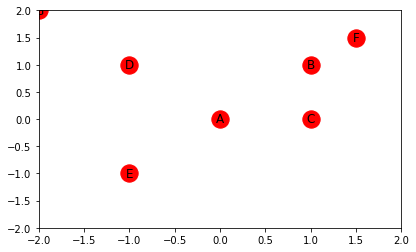

{('A', 'A'): 0.0, ('A', 'B'): 1.414, ('A', 'C'): 1.0, ('A', 'D'): 1.414, ('A', 'E'): 1.414, ('A', 'F'): 2.121, ('A', 'G'): 2.828, ('B', 'A'): 1.414, ('B', 'B'): 0.0, ('B', 'C'): 1.0, ('B', 'D'): 2.0, ('B', 'E'): 2.828, ('B', 'F'): 0.707, ('B', 'G'): 3.162, ('C', 'A'): 1.0, ('C', 'B'): 1.0, ('C', 'C'): 0.0, ('C', 'D'): 2.236, ('C', 'E'): 2.236, ('C', 'F'): 1.581, ('C', 'G'): 3.606, ('D', 'A'): 1.414, ('D', 'B'): 2.0, ('D', 'C'): 2.236, ('D', 'D'): 0.0, ('D', 'E'): 2.0, ('D', 'F'): 2.55, ('D', 'G'): 1.414, ('E', 'A'): 1.414, ('E', 'B'): 2.828, ('E', 'C'): 2.236, ('E', 'D'): 2.0, ('E', 'E'): 0.0, ('E', 'F'): 3.536, ('E', 'G'): 3.162, ('F', 'A'): 2.121, ('F', 'B'): 0.707, ('F', 'C'): 1.581, ('F', 'D'): 2.55, ('F', 'E'): 3.536, ('F', 'F'): 0.0, ('F', 'G'): 3.536, ('G', 'A'): 2.828, ('G', 'B'): 3.162, ('G', 'C'): 3.606, ('G', 'D'): 1.414, ('G', 'E'): 3.162, ('G', 'F'): 3.536, ('G', 'G'): 0.0} 

['G', 'D', 'A', 'C', 'B', 'F', 'E']
['C', 'A', 'B', 'F', 'D', 'G', 'E']


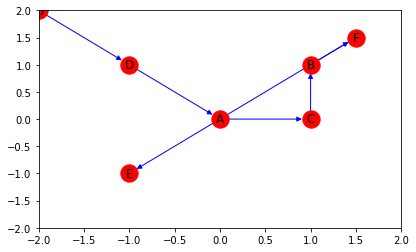

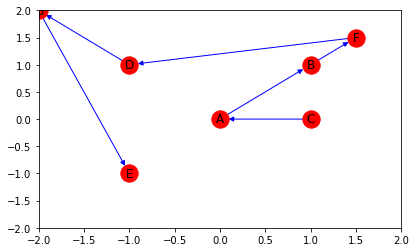

In [79]:
# (1) defining a larger set of cities
moreCities = {'A': (0,0), 'B': (1,1), 'C': (1,0), 'D': (-1,1), 'E': (-1,-1), 'F': (1.5,1.5), 'G': (-2,2)}
# (2)
showNodes(moreCities)
# (3)
moreDistances = distDict(moreCities)
print(moreDistances,"\n")
# (4)
gs3 = greedy_solution(moreCities)
print(gs3)
gs4 = greedy_solution(moreCities)
print(gs4)
# (5)
showPath(gs3, moreCities)
showPath(gs4, moreCities)

**5. Defining the process of simulated annealing**  
The class below defines the simulated annealing process.  This class is an adaptation of the class anneal.py found in the python code provided in this github https://github.com/chncyhn/simulated-annealing-tsp. You are not asked to changed this class, just go through it and try to understand it so as to get a better understanding of the *simulated annealing* algorithm.

In [80]:
# class to perform a simulated annealing
# must start with a set of nodes, all other parameters have defaults
class SimAnneal(object):
    def __init__(self, nodes, T=-1, alpha=-1, stopping_T=-1, stopping_iter=-1):
        # set of nodes
        self.nodes = nodes
        # number of nodes
        self.N = len(nodes)
        # set the temperature T to sqrt(N) if not specified
        self.T = math.sqrt(self.N) if T == -1 else T
        # set alpha (rate at which the temperature is decreased)
        self.alpha = 0.995 if alpha == -1 else alpha
        # set stopping temprature
        self.stopping_temperature = 0.00000001 if stopping_T == -1 else stopping_T
        # set stopping iteration
        self.stopping_iter = 100000 if stopping_iter == -1 else stopping_iter
        # start at iteration 1
        self.iteration = 1

        # calculate the distances
        self.allDist = distDict(nodes)
        
        # start with greedy solution
        self.cur_solution = greedy_solution(nodes)
        
        # so far, the best solution is the one we have
        self.best_solution = list(self.cur_solution)

        # calculate fitness of the current solution
        self.cur_fitness = self.fitness(self.cur_solution)
        # initial fitness for initial solution
        self.initial_fitness = self.cur_fitness
        # best fitness so far
        self.best_fitness = self.cur_fitness
        # build the fitness list as we explore solutions
        self.fitness_list = [self.cur_fitness]


    def fitness(self, sol):
        """ Objective value of a solution """
        return totalDist(sol, self.allDist)

    # acceptance propability
    def p_accept(self, candidate_fitness):
        """
        Probability of accepting if the candidate is worse than current
        Depends on the current temperature and difference between candidate and current
        """
        return math.exp(-abs(candidate_fitness - self.cur_fitness) / self.T)

    def accept(self, candidate):
        """
        Accept with probability 1 if candidate is better than current
        Accept with probabilty p_accept(..) if candidate is worse
        """
        candidate_fitness = self.fitness(candidate)
        # test if fitness is smaller then the current one
        if candidate_fitness < self.cur_fitness:
            self.cur_fitness = candidate_fitness
            self.cur_solution = candidate
            # test if fitness is better than best so far, keep it as best if so
            if candidate_fitness < self.best_fitness:
                self.best_fitness = candidate_fitness
                self.best_solution = candidate

        # if solution is worst than the current one, there is still a possibility to pursue it
        else:
            if random.random() < self.p_accept(candidate_fitness):
                self.cur_fitness = candidate_fitness
                self.cur_solution = candidate

    def anneal(self):
        """
        Execute simulated annealing algorithm
        """
        # go through the temperature schedule
        print(self.T)
        print(self.stopping_temperature)
        while (self.T >= self.stopping_temperature) and (self.iteration < self.stopping_iter):
            # explore current solution
            candidate = list(self.cur_solution)
            # modify the solution to switch two cities
            # first chosen city between [2,N-1] - not changing the first city
            l = random.randint(2, self.N - 1)
            # second city between [0,N-1] Not sure why ??
            i = random.randint(0, self.N - l)
            # the chosen nodes are switch
            candidate[i:(i + l)] = reversed(candidate[i:(i + l)])
            # perform acceptance test 
            self.accept(candidate)
            # multiply the temperature by alpha (this will reduce it)
            self.T *= self.alpha
            self.iteration += 1
            
            # add current fitness to list (to be able to display)
            self.fitness_list.append(self.cur_fitness)

        print('Best fitness obtained: ', self.best_fitness)
        print('Improvement over greedy heuristic: ',
              round((self.initial_fitness - self.best_fitness) / (self.initial_fitness), 4))

        return self.best_solution
    
    def plot_learning(self):
        """
        Plot the fitness through iterations
        """
        plt.plot([i for i in range(len(self.fitness_list))], self.fitness_list)
        plt.ylabel('Fitness')
        plt.xlabel('Iteration')
        plt.show()


#### 6. Refining a greedy solution through simulated annealing.

**(Q4 - TO DO)** Put comments in the code below explaining what it does.  Also run it a few times.  It will show you how there can be improvement (or not) from the greedy solution to the annealed one.

Solution ['E', 'A', 'C', 'B', 'D'] takes a total of 5.414


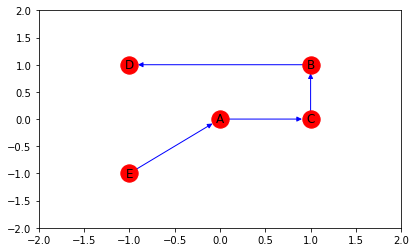

2.23606797749979
1e-08
Best fitness obtained:  5.414
Improvement over greedy heuristic:  0.0977


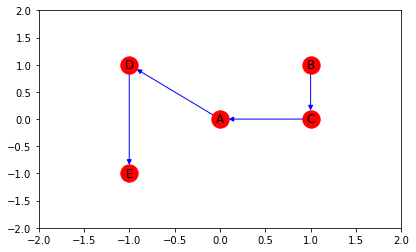

In [89]:
# use the greedy solution on the data points
firstSol = greedy_solution(cities)
# calculate the euclidean distances of all the data points and store it in a dict
distances = distDict(cities)
# simple print statement to print the greedy solution path as calculated above
# and the total distance of said path using the method totalDist with the input
# of the sultion and the dict of distances
print('Solution {} takes a total of {}'.format(firstSol,totalDist(firstSol, distances)))
# show the path with the lines demonstrating the path taken by the greedy solution
showPath(firstSol, cities)
# use the Simulated annealing method on the same data points. prepping the data through the constructor so it is ready
# for other simulated annealing calls such as .anneal(), calculates the greedy method first but then builds the fitness
# for the improved method
sa = SimAnneal(cities)
# execute and display the similated annealing method on the data executing the best fitness obtained and the 
# improvement on the greedy method
betterSol = sa.anneal()
# show the path as we did before but now with the simulated annealing method 
showPath(betterSol, cities)

**7. Moving toward a larger example**  
There are a set of coordinates defined in the file *coord.txt* (available in the Jupyter Notebooks module in Brightspace). This data file is also from the github https://github.com/chncyhn/simulated-annealing-tsp.  It contains a larger example with 45 cities, to test.  Here is the beginning of the file:

1 0 0  
2 3 5  
3 2.5 9  
4 48 16  
5 48 17  
6 69 16  
...

Make sure to put the file *coord.txt* in the same repertory as your notebook or modify the path below when opening the file to read.  We will assume the first number is the label, and the other two numbers are the coordinates.

In [81]:
# reading the coordinates
manyCities = {}
with open('coord.txt','r') as f:
    i = 0
    for line in f.readlines():
        line = [float(x.replace('\n','')) for x in line.split(' ')]
        label = str(int(line[0]))
        manyCities[label] = (line[1], line[2])
        i += 1

Show the nodes from that larger set of cities.

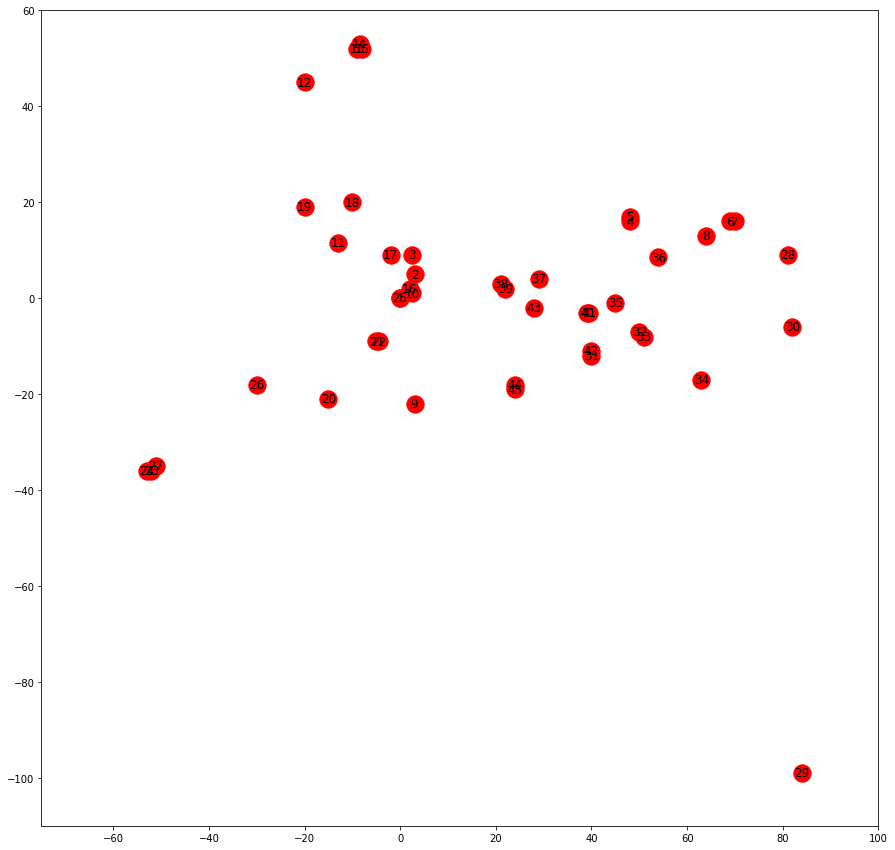

In [82]:
showNodes(manyCities, size=(15,15), xLim=[-75,100], yLim=[-110,60])

Testing the annealing process with the larger example. The steps are the same as the ones you had to comment in Question 4. Look at the additional step *plot_learning*, it shows the value of the fitness function as the annealing process occurs.  Run it multiple times, it is a probabilistic approach, so the result might be slightly different each time.

Solution ['21', '22', '1', '25', '10', '16', '2', '3', '17', '11', '18', '19', '12', '13', '15', '14', '38', '39', '43', '37', '40', '41', '35', '32', '33', '42', '31', '44', '45', '9', '20', '26', '27', '23', '24', '4', '5', '36', '8', '6', '7', '28', '30', '34', '29'] takes a total of 590.051


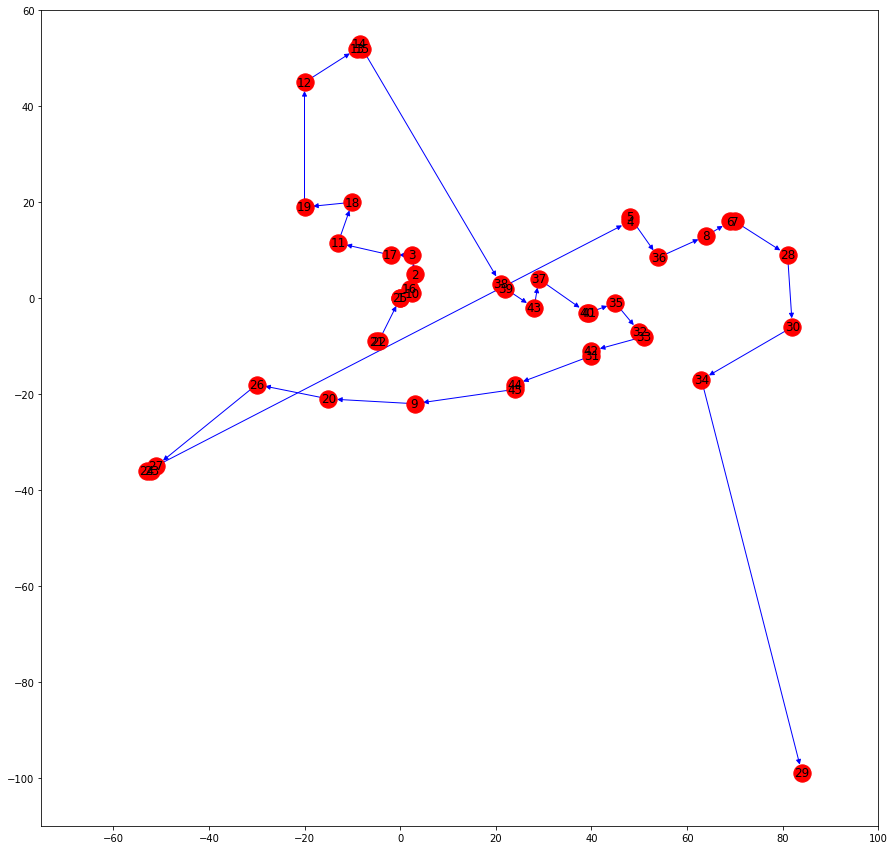

6.708203932499369
1e-08
Best fitness obtained:  528.731
Improvement over greedy heuristic:  0.1262


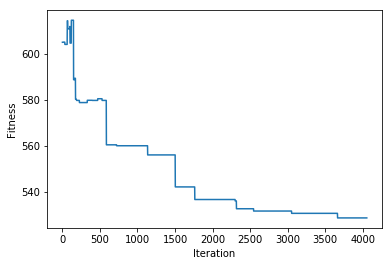

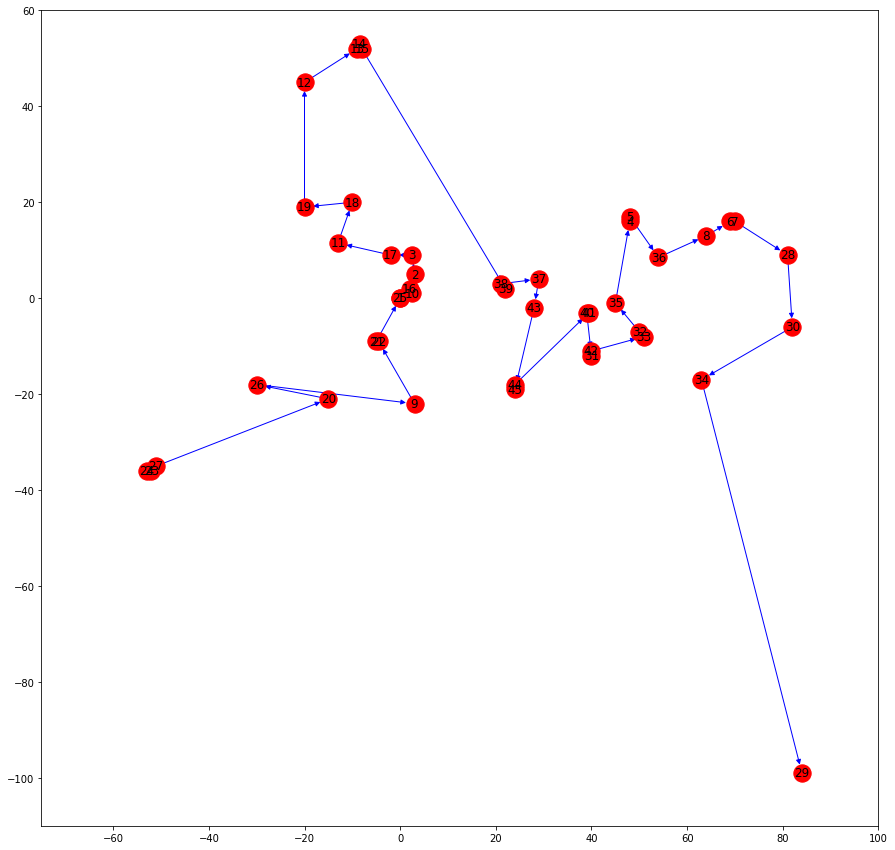

In [91]:
firstSol = greedy_solution(manyCities)
distances = distDict(manyCities)
print('Solution {} takes a total of {}'.format(firstSol,totalDist(firstSol, distances)))
showPath(firstSol, manyCities, size=(15,15), xLim=[-75,100], yLim=[-110,60])
sa = SimAnneal(manyCities)
betterSol = sa.anneal()
sa.plot_learning()
showPath(betterSol, manyCities, size=(15,15), xLim=[-75,100], yLim=[-110,60])

**(Q5 - TO DO)** Try the annealing again, but provide a different temperature schedule, by changing alpha, and the starting and stopping temperatures.  These are all parameters to the class which can be set.  Try also changing the number of iterations to do.  Explore 3-4 variations below.

6.708203932499369
1e-08
Best fitness obtained:  606.336
Improvement over greedy heuristic:  0.0


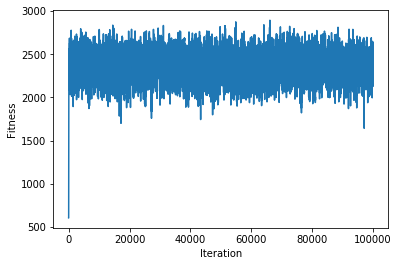

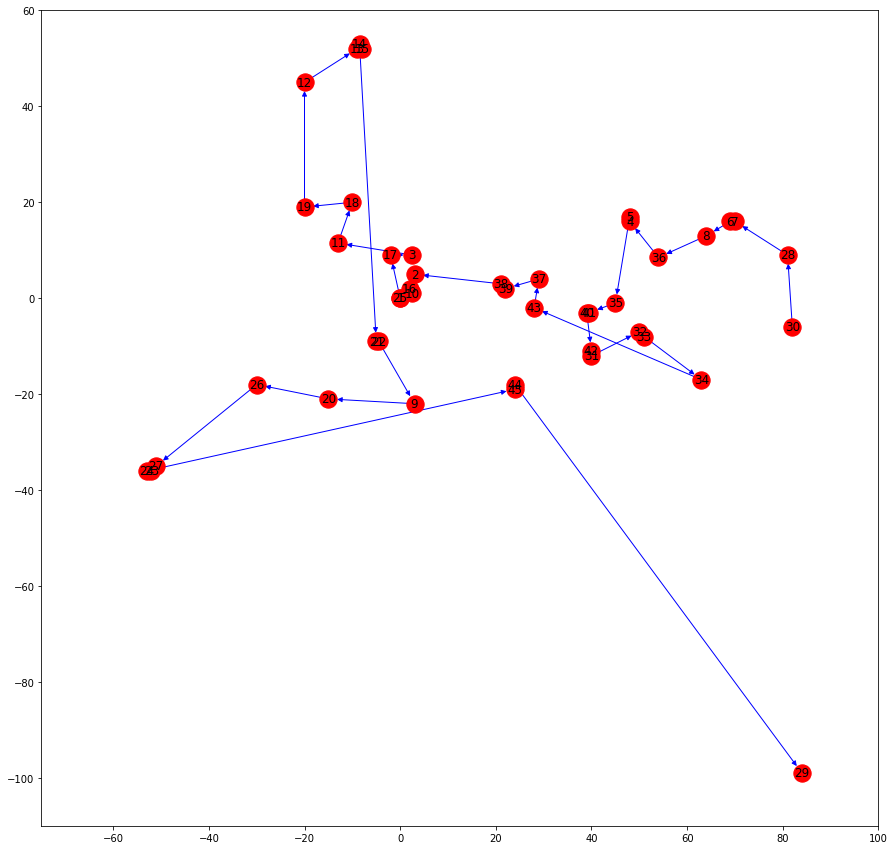

6.708203932499369
1e-08
Best fitness obtained:  663.791
Improvement over greedy heuristic:  0.0


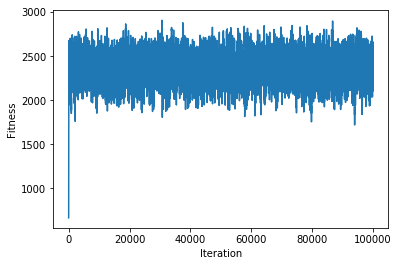

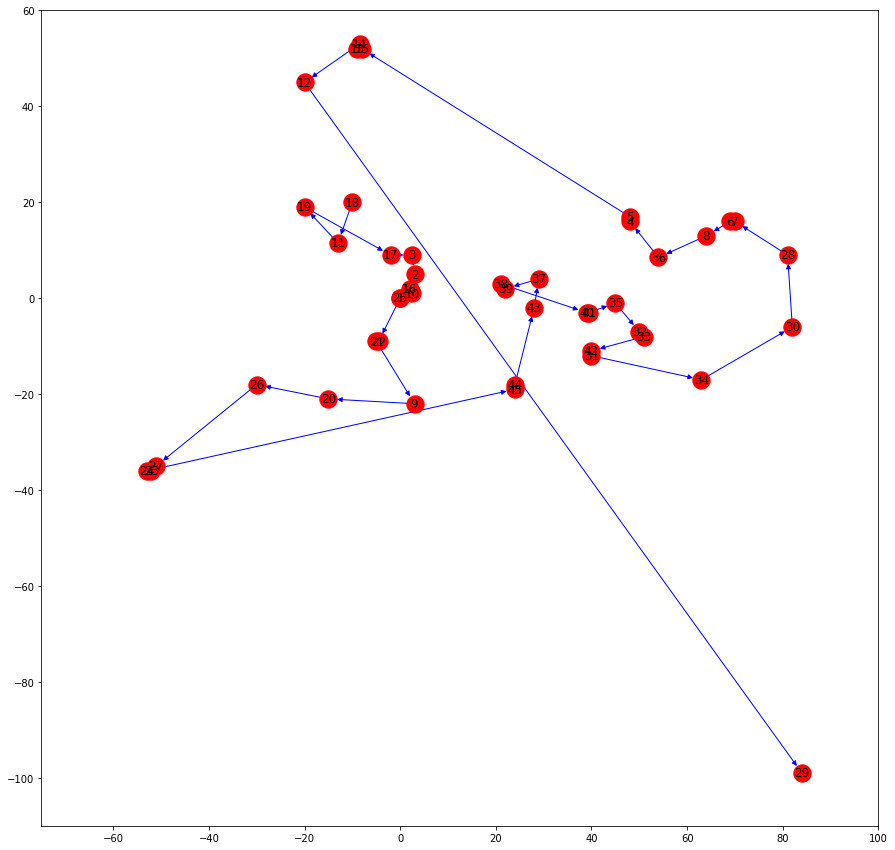

6.708203932499369
1e-08
Best fitness obtained:  524.048
Improvement over greedy heuristic:  0.0182


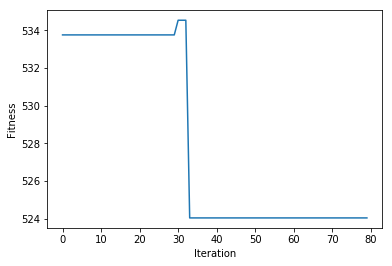

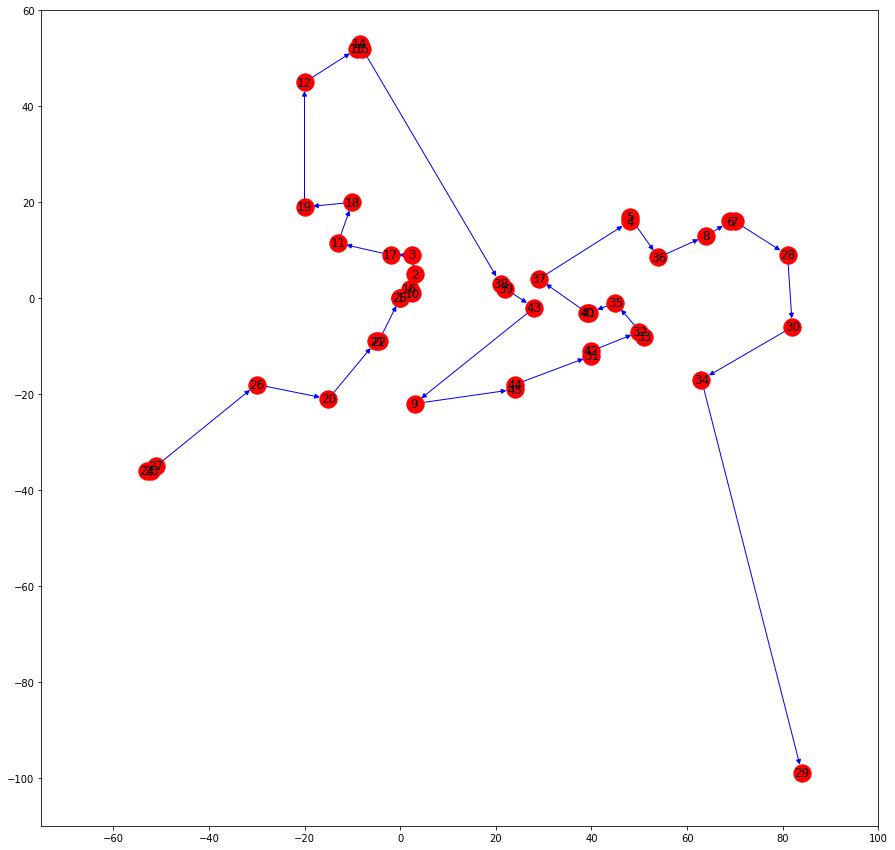

6.708203932499369
1
Best fitness obtained:  577.63
Improvement over greedy heuristic:  0.0291


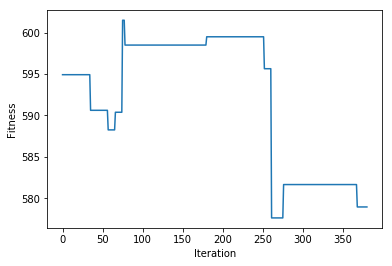

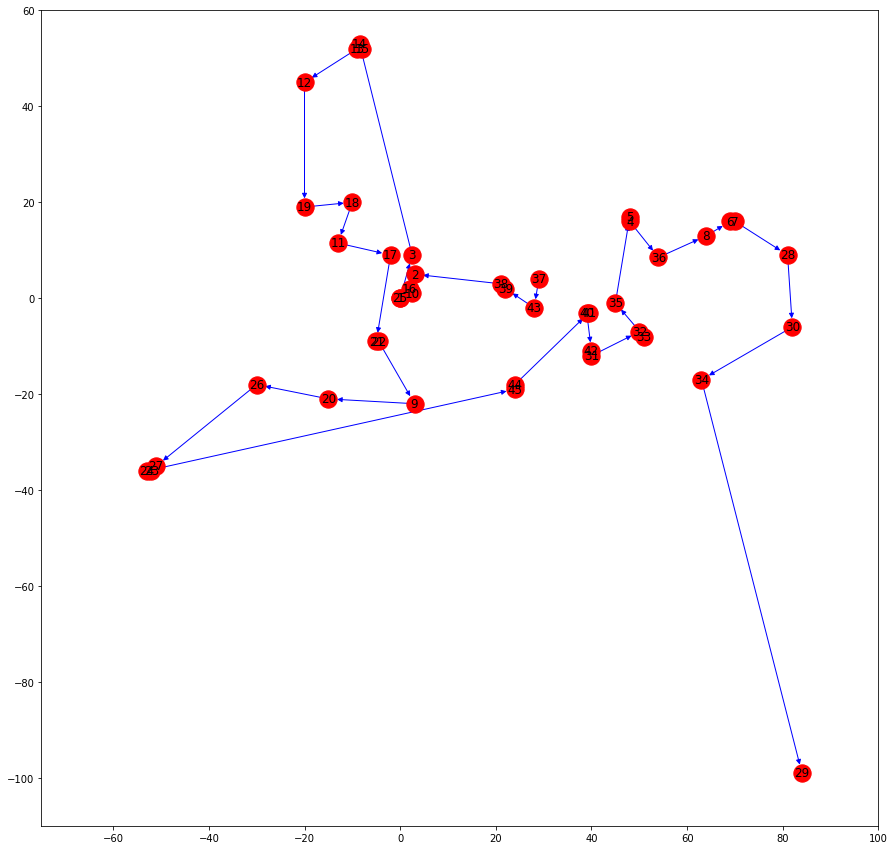

In [104]:
# (TO DO) Look at this line from the SimAnneal class above
# def __init__(self, nodes, T=-1, alpha=-1, stopping_T=-1, stopping_iter=-1):
# This means that parameters T, alpha, stopping_T and stopping_iter all have defaults, but could be changed
# For example, calling SimAnneal(manyCities, stopping_iter=100) means that I set a maximum of 100 iterations.
# Try a few variations and look at the differences

# Test 1 ...
sa = SimAnneal(manyCities, alpha=5)
betterSol = sa.anneal()
sa.plot_learning()
showPath(betterSol, manyCities, size=(15,15), xLim=[-75,100], yLim=[-110,60])

# Test 2 ...
sa = SimAnneal(manyCities, alpha= 100)
betterSol = sa.anneal()
sa.plot_learning()
showPath(betterSol, manyCities, size=(15,15), xLim=[-75,100], yLim=[-110,60])

# Test 3 ...
sa = SimAnneal(manyCities, stopping_iter=80)
betterSol = sa.anneal()
sa.plot_learning()
showPath(betterSol, manyCities, size=(15,15), xLim=[-75,100], yLim=[-110,60])

# Test 4 ...
sa = SimAnneal(manyCities, stopping_T=1)
betterSol = sa.anneal()
sa.plot_learning()
showPath(betterSol, manyCities, size=(15,15), xLim=[-75,100], yLim=[-110,60])

**(Optional - TO DO)**  If you are interested in performance analysis, you could apply a full-solution space exploration algorithm (such as dynamic programming) to the manyCities graph to find the optimal solution.  Once you have the optimal solution, then you would be able to run *simulated annealing* a 1000 times and measure how many times the simulated annealing reaches that optimal solution (or a nearby solution).  You could compare that to running 1000 times the greedy search and measuring how many times the greedy search reaches the optimal solution.  Which is better???

#### Signature

I, Felix Singerman, declare that the answers provided in this notebook are my own.